In [1]:
#QE_R02_S21_nm960_-211.815_-0.395.fits

import glob
import os
from lsst import afw
print(afw.version.__version__)
from lsst.daf.persistence import Butler
from lsst.eotest.sensor import MaskedCCD, makeAmplifierGeometry

from exploreRun import exploreRun
from lsst.eo_utils.base.image_utils import get_ccd_from_id,\
    get_amp_list, get_data_as_read, sort_sflats

from lsst.eo_utils.base.data_access import get_data_for_run

import lsst.eotest.image_utils as imutil
import pylab

from astropy.io import fits
from astropy.stats import mad_std

import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift

import math
from scipy.ndimage import gaussian_filter

from mytool import plotonesensor_ITL, plotonesensor_ITL_smooth, create_combined_ITL
import numpy as np
import numpy

import matplotlib.pyplot as plt

%matplotlib inline

20.0.0-4-gde602ef96+1
20.0.0-4-gde602ef96+1


[ 319.994  324.969  349.982  374.975  400.019  424.965  450.035  475.003
  500.018  525.002  550.029  575.023  599.982  619.997  624.979  650.012
  675.004  700.03   725.012  750.022  774.987  799.976  824.988  850.022
  869.967  875.002  899.999  919.999  925.012  949.965  975.002  999.976
 1025.028 1050.014 1075.002 1099.99 ]


Text(0.5, 1.0, 'Response Curve/SED for CCOB$_{Y}$')

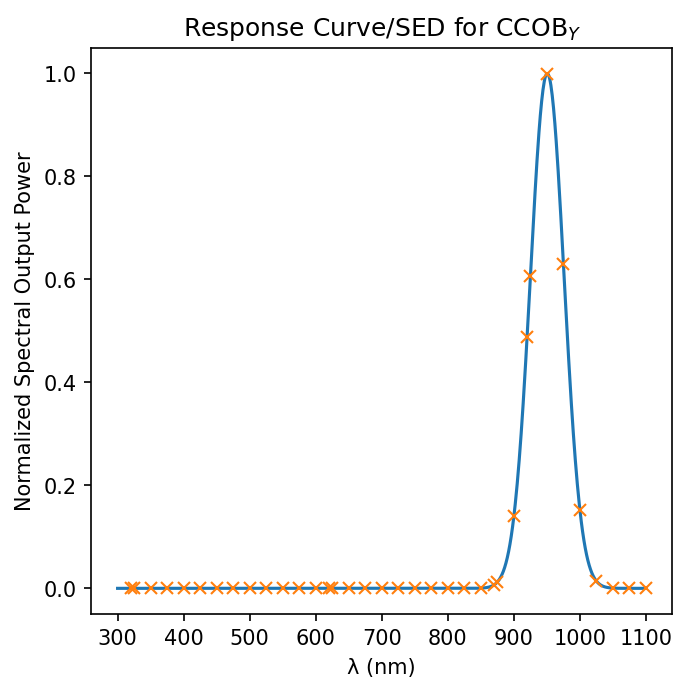

In [2]:
superbiaspath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superbias/RTM-013/RTM-013-10982-S21_superbias_normal.fits"
superdarkpath = "/gpfs/slac/lsst/fs1/u/echarles/DATA/analysis/ts8/superdark/RTM-013/RTM-013-10982-S21_superdark_normal.fits"
qeflatpath = glob.glob("/gpfs/slac/lsst/fs3/g/data/jobHarness/jh_stage/LCA-11021_RTM/LCA-11021_RTM-013/10982/qe_raft_acq/v0/85192/S21/*_lambda_flat_*")
qeflatpath.sort()

# array of wavelengths
wls = numpy.array([ get_ccd_from_id(None, aqeflatpath, []).md.md["MONOWL"] for aqeflatpath in qeflatpath ])
print(wls)



# SED plot for YELLOW band
fig, axs = pylab.subplots(figsize=(5,5),dpi=150)


wavelengths_list = [365, 466.6, 622.6, 759.9, 845.7, 950.5]
width_of_wavelength_list = [12, 25, 18, 28, 32, 60]
width_of_wavelength_list_converted = []
for num in width_of_wavelength_list:
    z = num / 2.355
    width_of_wavelength_list_converted.append(z)

mu = wavelengths_list[5]
sigma = width_of_wavelength_list_converted[5]

a = 1    # to normalize
x = numpy.arange(300,1100,1)  
         # gaussians #
y = a*numpy.exp(-(x-mu)**2/(2*sigma**2))
pylab.plot(x, y)

weights = numpy.interp(wls, x, y)
pylab.plot(wls, weights,"x")

pylab.xlabel("λ (nm)")
pylab.ylabel("Normalized Spectral Output Power")
pylab.title("Response Curve/SED for CCOB$_{Y}$")

In [3]:
def create_ccob(img_list):
    num_ch = 16
    
    yel_arr = [None] * num_ch
    normedimg_arr = [None] * num_ch
    MEDIAN = None

    fname = "/gpfs/slac/lsst/fs1/u/combet/DATA/CCOB_QE/fits/QE_R02_S21_nm960_-211.815_-0.395.fits"     
    ccob_yel = get_ccd_from_id(None, fname, [])

    for ch in range(num_ch):    
        yel = get_data_as_read(ccob_yel,ch + 1,["imaging"])["imaging"]    # QE data array for CCOBy flat field image
        MEDIAN = numpy.median(yel)                                        # median (not mean, avoiding outliers) of QE data array for CCOBy, will normalize COMBINED with this
        normedimg = img_list[ch] / numpy.median(img_list[ch]) * MEDIAN    # normalizing COMBINED against the CCOB amp-by-amp to the level of the CCOB median 
        normedimg_arr[ch] = normedimg                                     # adding data at this amp to data array
        yel_arr[ch] = yel  
        
    return yel_arr, normedimg_arr

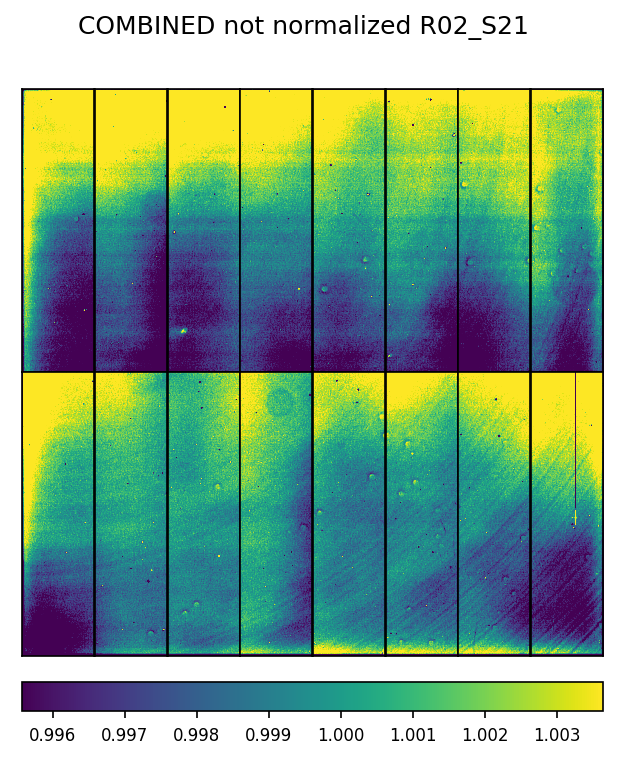

([array([[56784., 53361., 51949., ..., 50254., 50235., 50827.],
         [61062., 60312., 59336., ..., 56612., 56318., 55665.],
         [62446., 62679., 62024., ..., 59537., 58259., 58273.],
         ...,
         [69134., 68732., 68956., ..., 67444., 66689., 65741.],
         [68703., 68448., 69122., ..., 67309., 66841., 65931.],
         [68437., 68150., 68220., ..., 67473., 66519., 65599.]],
        dtype=float32),
  array([[56230., 54362., 52813., ..., 54219., 55194., 57132.],
         [61239., 60338., 59850., ..., 60265., 60607., 60833.],
         [62519., 62945., 62441., ..., 63540., 62451., 62990.],
         ...,
         [68576., 68487., 68892., ..., 68863., 68896., 68949.],
         [68245., 68705., 68839., ..., 68704., 68348., 68218.],
         [67257., 67712., 68277., ..., 68181., 67906., 68787.]],
        dtype=float32),
  array([[56581., 54029., 52441., ..., 54116., 55270., 56992.],
         [61375., 59848., 59757., ..., 61003., 60837., 60991.],
         [62737., 62385., 

In [4]:
### GOAL: show combined flat for full sensor (all amplifiers) from ts8-stand narrowband QE flats weighted and summed to make combined ###

title = "COMBINED not normalized R02_S21"
img_list = create_combined_ITL(superdarkpath, superbiaspath, qeflatpath, weights, title)    # create_combined returns img_list at end of function
create_ccob(img_list)   # calling this function creates the combined flat, displays it, returns the img_list with combined data arrays, and creates data array lists for CCOB and combined normalized against CCOB


# Let's see how the Combined flat for FULL CCD SENSOR looks
# creating a broadband flat (Combined) from summed up narrow band flats weighted by QE response to BLUE wavelength

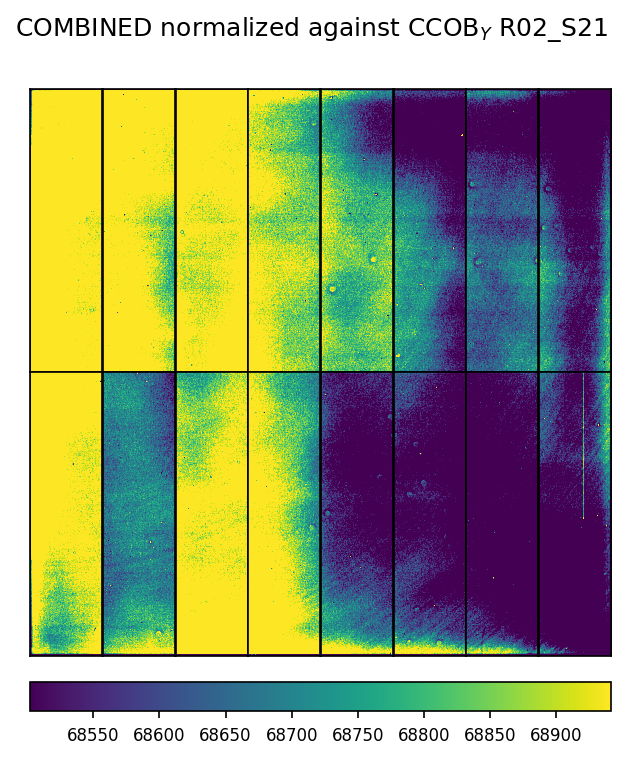

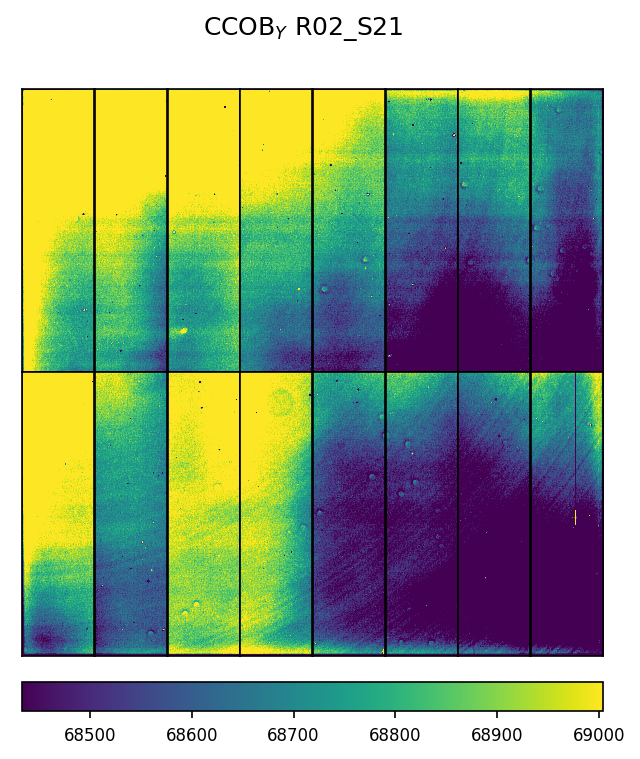

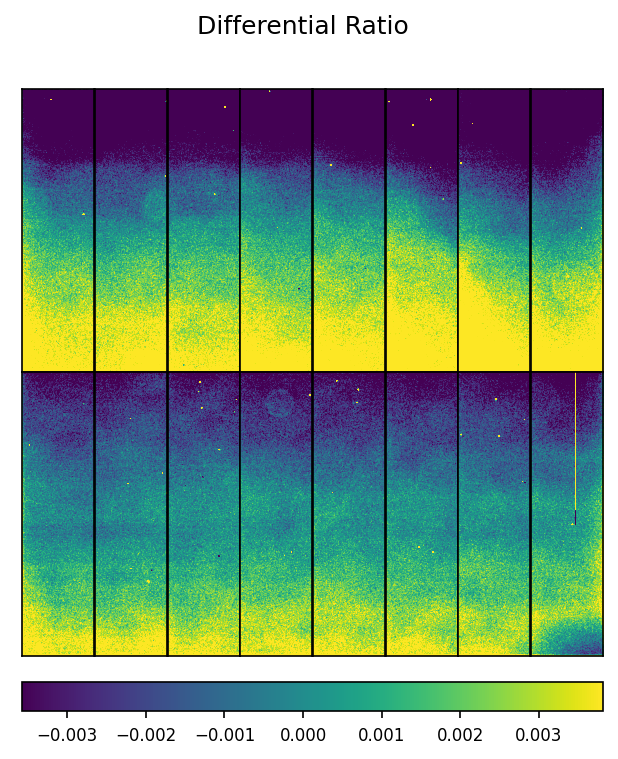

In [5]:
# default color map
num_ch = 16
normedimg_arr, yel_arr = create_ccob(img_list)    # create_ccob returns these two lists to be used in plotonesensor

# plot normalized, COMBINED flat
plotonesensor_ITL(normedimg_arr, 'COMBINED normalized against CCOB$_{Y}$ R02_S21')

# plot CCOBred flat
plotonesensor_ITL(yel_arr, 'CCOB$_{Y}$ R02_S21')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - yel_arr[i]) / yel_arr[i]
plotonesensor_ITL(diff_arr, 'Differential Ratio')

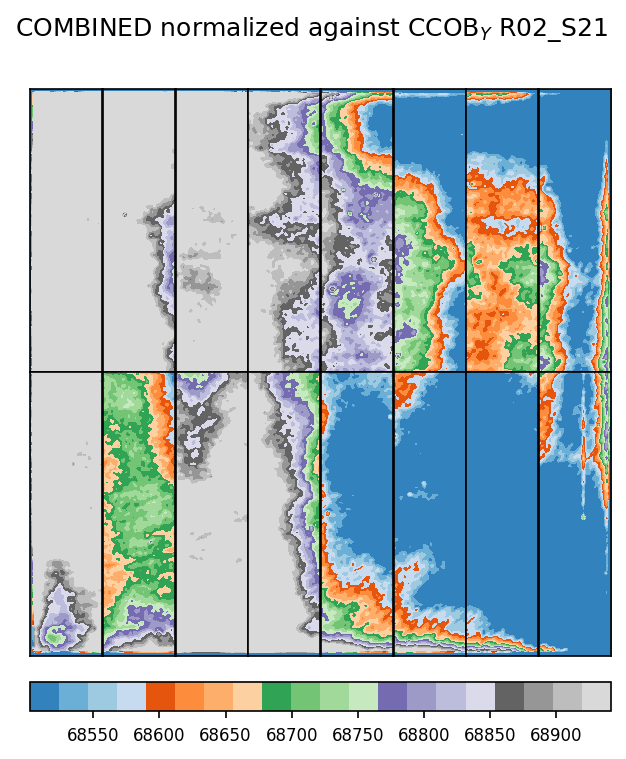

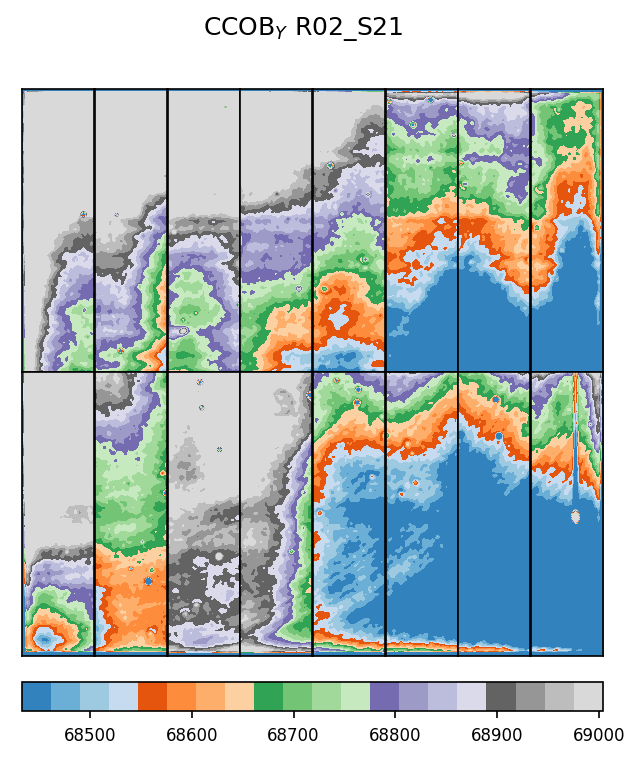

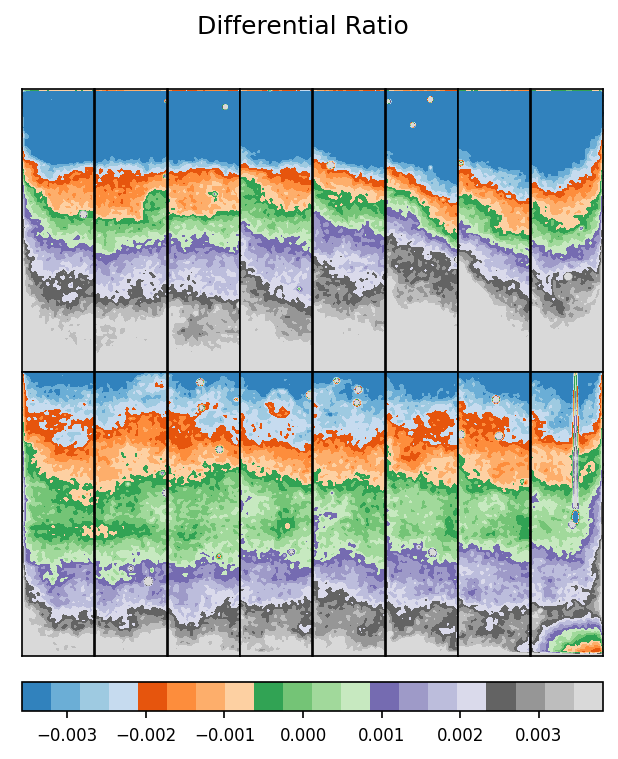

In [6]:
# smooth color map

# plot normalized, COMBINED flat
plotonesensor_ITL_smooth(normedimg_arr, 'COMBINED normalized against CCOB$_{Y}$ R02_S21')

# plot CCOBred flat
plotonesensor_ITL_smooth(yel_arr, 'CCOB$_{Y}$ R02_S21')

# plot Ratio flat, the one of interest!
diff_arr = [None] * num_ch
for i in range(num_ch):
    diff_arr[i] = (normedimg_arr[i] - yel_arr[i]) / yel_arr[i]
plotonesensor_ITL_smooth(diff_arr, 'Differential Ratio')